# 🚀 **RAG (Retrieval-Augmented Generation) con Métricas de Evaluación**

## 📋 **Objetivo del Ejercicio**

Este notebook implementa un sistema completo de **RAG** (Retrieval-Augmented Generation) y evalúa su rendimiento usando múltiples métricas de evaluación automática y comparación con respuestas sin RAG.

### 🎯 **Lo que se aprendera:**

1. **Implementar un sistema RAG completo** usando Gemini + ChromaDB
2. **Evaluar respuestas** con métricas automáticas (BLEU, ROUGE, BERTScore)
3. **Comparar rendimiento** RAG vs No-RAG
4. **Análizar resultados** y visualizar diferencias de calidad
5. **Optimizar parámetros** del sistema RAG

### 🛠️ **Tecnologías utilizadas:**
- **RAG**: Google Gemini, ChromaDB, SentenceTransformers
- **Métricas**: NLTK (BLEU), ROUGE-score, BERTScore
- **Visualización**: Matplotlib, Seaborn, Pandas

## 📦 **1. Configuración del Entorno e Instalación de Librerías**

Primero instalamos todas las librerías necesarias para nuestro sistema RAG y las métricas de evaluación.

In [ ]:
# ================= INSTALACIÓN DE LIBRERÍAS ==================
!pip install chromadb sentence-transformers google-generativeai
!pip install nltk rouge-score matplotlib seaborn bert-score pandas rank_bm25 --upgrade

print("✅ Todas las librerías instaladas correctamente!")

In [12]:
# ================= IMPORTACIONES ==================
import os
import google.generativeai as genai
from sentence_transformers import SentenceTransformer
import chromadb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Para métricas de evaluación
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.tokenize import word_tokenize
from rouge_score import rouge_scorer
from rank_bm25 import BM25Okapi

try:
    from bert_score import score
    bertscore_available = True
    print('✅ BERTScore disponible!')
except ImportError:
    print('⚠️ BERTScore no disponible - usando scores simulados')
    bertscore_available = False

# Descargar recursos de NLTK
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)

print("✅ Todas las librerías importadas correctamente!")

✅ BERTScore disponible!
✅ Todas las librerías importadas correctamente!


In [ ]:
# ================= CONFIGURACIÓN DE GEMINI ==================
os.environ["GEMINI_API_KEY"] = "TU_API_KEY_AQUI"
genai.configure(api_key=os.environ["GEMINI_API_KEY"])

# Verificar conexión
try:
    model = genai.GenerativeModel("models/gemini-2.5-flash")
    test_response = model.generate_content("Hola, ¿funciona la conexión?")
    print("✅ Conexión con Gemini exitosa!")
    print(f"Respuesta de prueba: {test_response.text[:50]}...")
except Exception as e:
    print(f"❌ Error de conexión con Gemini: {e}")
    print("Verifica tu API Key en la configuración.")

✅ Conexión con Gemini exitosa!
Respuesta de prueba: ¡Hola! Sí, la conexión funciona perfectamente de m...


## 📄 **2. Carga y Preprocesamiento de Documentos**

En esta sección cargaremos los documentos de texto y los prepararemos para el sistema RAG.

In [14]:
# ================= CARGA DEL DOCUMENTO ==================

document_text = """
La mecánica cuántica es una teoría fundamental en física que describe las propiedades de la naturaleza a escala de átomos y partículas subatómicas.

Niels Bohr propuso en 1913 un modelo atómico revolucionario. En el modelo de Bohr, los electrones orbitan alrededor del núcleo en órbitas circulares específicas o niveles de energía. Este modelo explicaba exitosamente el espectro del hidrógeno.

Max Planck introdujo en 1900 la idea de que la energía se emite en paquetes discretos llamados cuantos. Esta hipótesis marcó el nacimiento de la teoría cuántica. Planck recibió el Premio Nobel de Física en 1918 por su descubrimiento.

Albert Einstein desarrolló la teoría de la relatividad, que incluye tanto la relatividad especial (1905) como la relatividad general (1915). La relatividad especial cambió nuestra comprensión del espacio y el tiempo, estableciendo que la velocidad de la luz es constante en todos los marcos de referencia.

Werner Heisenberg formuló en 1927 el principio de incertidumbre, que establece que no es posible determinar simultáneamente y con precisión arbitraria ciertos pares de propiedades físicas de una partícula, como la posición y el momento.

Erwin Schrödinger desarrolló la ecuación de Schrödinger en 1926, que describe cómo evoluciona el estado cuántico de un sistema físico con el tiempo. Esta ecuación es fundamental en la mecánica cuántica moderna.

La dualidad onda-partícula es un concepto que describe cómo la materia y la energía exhiben propiedades tanto de ondas como de partículas. Este fenómeno fue demostrado experimentalmente por Thomas Young en su famoso experimento de la doble rendija.

Marie Curie fue pionera en el estudio de la radioactividad, término que ella misma acuñó. Junto con su esposo Pierre Curie, descubrió los elementos polonio y radio. Marie Curie fue la primera mujer en ganar un Premio Nobel y la única persona en ganar premios Nobel en dos ciencias diferentes: Física (1903) y Química (1911).

El efecto fotoeléctrico, explicado por Einstein en 1905, demostró la naturaleza cuántica de la luz. Este trabajo le valió el Premio Nobel de Física en 1921. El efecto muestra que la luz puede arrancar electrones de un material, pero solo si la frecuencia de la luz supera un valor umbral específico.

La física cuántica ha llevado al desarrollo de tecnologías modernas como láseres, transistores, y computadores cuánticos. Los ordenadores cuánticos prometen revolucionar la computación al utilizar principios como la superposición y el entrelazamiento cuántico.
"""

print(f"📊 Documento cargado:")
print(f"   - Longitud: {len(document_text)} caracteres")
print(f"   - Palabras aproximadas: {len(document_text.split())} palabras")
print(f"   - Primeras 200 caracteres: '{document_text[:200]}...'")

📊 Documento cargado:
   - Longitud: 2526 caracteres
   - Palabras aproximadas: 388 palabras
   - Primeras 200 caracteres: '
La mecánica cuántica es una teoría fundamental en física que describe las propiedades de la naturaleza a escala de átomos y partículas subatómicas.

Niels Bohr propuso en 1913 un modelo atómico revol...'


In [15]:
# ================= FUNCIÓN DE CHUNKING ==================
def chunk_text(text, chunk_size=100, overlap=20):
    """
    Divide el texto en fragmentos (chunks) con solapamiento.

    Args:
        text: Texto a dividir
        chunk_size: Tamaño del chunk en palabras
        overlap: Solapamiento entre chunks en palabras

    Returns:
        Lista de chunks de texto
    """
    words = text.split()
    chunks = []

    for i in range(0, len(words), chunk_size - overlap):
        chunk = " ".join(words[i:i + chunk_size])
        if chunk.strip():  # Solo agregar chunks no vacíos
            chunks.append(chunk.strip())

    return chunks

# Aplicar chunking al documento
chunks = chunk_text(document_text, chunk_size=100, overlap=20)

print(f"📊 Chunking completado:")
print(f"   - Total de chunks: {len(chunks)}")
print(f"   - Tamaño promedio: {np.mean([len(chunk.split()) for chunk in chunks]):.1f} palabras")
print(f"   - Rango de tamaños: {min([len(chunk.split()) for chunk in chunks])}-{max([len(chunk.split()) for chunk in chunks])} palabras")

print(f"\n📄 Ejemplo de 3 primeros chunks:")
for i, chunk in enumerate(chunks[:3]):
    print(f"\n--- Chunk {i+1} ---")
    print(f"{chunk[:150]}..." if len(chunk) > 150 else chunk)

📊 Chunking completado:
   - Total de chunks: 5
   - Tamaño promedio: 93.6 palabras
   - Rango de tamaños: 68-100 palabras

📄 Ejemplo de 3 primeros chunks:

--- Chunk 1 ---
La mecánica cuántica es una teoría fundamental en física que describe las propiedades de la naturaleza a escala de átomos y partículas subatómicas. Ni...

--- Chunk 2 ---
el nacimiento de la teoría cuántica. Planck recibió el Premio Nobel de Física en 1918 por su descubrimiento. Albert Einstein desarrolló la teoría de l...

--- Chunk 3 ---
simultáneamente y con precisión arbitraria ciertos pares de propiedades físicas de una partícula, como la posición y el momento. Erwin Schrödinger des...


## 🧠 **3. Creación de los Componentes del Sistema RAG**

Ahora crearemos el nucleo de nuestro sistema RAG: la base de datos vectorial y el sistema de embeddings.

In [16]:
# ================= INICIALIZACIÓN DE EMBEDDINGS ==================
print("🔄 Inicializando modelo de embeddings...")
embedder = SentenceTransformer("all-MiniLM-L6-v2")
print("✅ Modelo de embeddings cargado!")

# ================= CREACIÓN DE BASE DE DATOS VECTORIAL ==================
print("🔄 Inicializando ChromaDB...")
client = chromadb.Client()

collection_name = "physics_knowledge_base"
try:
    client.delete_collection(collection_name)
    print(f"🗑️ Colección '{collection_name}' anterior eliminada")
except:
    pass

collection = client.get_or_create_collection(collection_name)
print("✅ Base de datos vectorial creada!")

# ================= GENERACIÓN Y ALMACENAMIENTO DE EMBEDDINGS ==================
print("🔄 Generando embeddings para los chunks...")
embeddings = embedder.encode(chunks).tolist()

# Agregar documentos a la colección
for i, chunk in enumerate(chunks):
    collection.add(
        documents=[chunk],
        embeddings=[embeddings[i]],
        ids=[f"chunk_{i}"]
    )

print(f"✅ {len(chunks)} chunks procesados y almacenados en la base vectorial!")
print(f"📊 Dimensiones del embedding: {len(embeddings[0])}")

# Verificar que todo está funcionando
result = collection.query(
    query_texts=["¿Qué es la mecánica cuántica?"],
    n_results=2
)

print(f"\n🧪 Prueba de funcionamiento:")
print(f"   - Chunks recuperados: {len(result['documents'][0])}")
print(f"   - Primer resultado: '{result['documents'][0][0][:100]}...'")

🔄 Inicializando modelo de embeddings...
✅ Modelo de embeddings cargado!
🔄 Inicializando ChromaDB...
🗑️ Colección 'physics_knowledge_base' anterior eliminada
✅ Base de datos vectorial creada!
🔄 Generando embeddings para los chunks...
✅ 5 chunks procesados y almacenados en la base vectorial!
📊 Dimensiones del embedding: 384

🧪 Prueba de funcionamiento:
   - Chunks recuperados: 2
   - Primer resultado: 'Young en su famoso experimento de la doble rendija. Marie Curie fue pionera en el estudio de la radi...'


## 🎯 **4. Generación de Respuestas con RAG**

Ahora implementaremos las funciones para generar respuestas tanto con RAG como sin RAG para poder compararlas.

In [17]:
# ================= CLASE RAG ==================
class RAGSystem:
    def __init__(self, model, embedder, collection):
        self.model = model
        self.embedder = embedder
        self.collection = collection

    def retrieve_context(self, query, n_results=3):
        """Recupera chunks relevantes para la consulta"""
        results = self.collection.query(
            query_texts=[query],
            n_results=n_results
        )
        return results['documents'][0]

    def generate_with_rag(self, query, n_results=3):
        """Genera respuesta usando RAG"""
        # Recuperar contexto relevante
        relevant_chunks = self.retrieve_context(query, n_results)
        context = " ".join(relevant_chunks)

        # Crear prompt con contexto
        prompt = f"""Basándote en el siguiente contexto, responde la pregunta de manera precisa y completa. Si la información no está en el contexto, indícalo claramente.

Contexto:
{context}

Pregunta: {query}

Respuesta:"""

        response = self.model.generate_content(prompt)
        return {
            'answer': response.text,
            'context': relevant_chunks,
            'context_text': context
        }

    def generate_without_rag(self, query):
        """Genera respuesta sin usar RAG (solo conocimiento del modelo)"""
        prompt = f"""Responde la siguiente pregunta usando tu conocimiento general. No menciones que no tienes acceso a documentos específicos.

Pregunta: {query}

Respuesta:"""

        response = self.model.generate_content(prompt)
        return {
            'answer': response.text,
            'context': [],
            'context_text': ""
        }

# Inicializar sistema RAG
rag_system = RAGSystem(model, embedder, collection)

print("✅ Sistema RAG inicializado correctamente!")

✅ Sistema RAG inicializado correctamente!


In [18]:
# ================= PRUEBA DEL SISTEMA RAG ==================
# Pregunta de ejemplo
test_query = "¿Qué científico propuso un modelo atómico en 1913?"

print("🧪 Probando el sistema RAG...")
print(f"Pregunta: {test_query}")

# Respuesta con RAG
print(f"\n{'='*50}")
print("🔍 RESPUESTA CON RAG:")
print(f"{'='*50}")
rag_response = rag_system.generate_with_rag(test_query)
print(f"Respuesta: {rag_response['answer']}")
print(f"\nContexto utilizado:")
for i, chunk in enumerate(rag_response['context'], 1):
    print(f"  {i}. {chunk[:100]}...")

# Respuesta sin RAG
print(f"\n{'='*50}")
print("📚 RESPUESTA SIN RAG (Solo conocimiento del modelo):")
print(f"{'='*50}")
no_rag_response = rag_system.generate_without_rag(test_query)
print(f"Respuesta: {no_rag_response['answer']}")

print(f"\n✅ Prueba completada. Ambas respuestas generadas correctamente.")

🧪 Probando el sistema RAG...
Pregunta: ¿Qué científico propuso un modelo atómico en 1913?

🔍 RESPUESTA CON RAG:
Respuesta: Niels Bohr propuso en 1913 un modelo atómico.

Contexto utilizado:
  1. La mecánica cuántica es una teoría fundamental en física que describe las propiedades de la naturale...
  2. el nacimiento de la teoría cuántica. Planck recibió el Premio Nobel de Física en 1918 por su descubr...
  3. simultáneamente y con precisión arbitraria ciertos pares de propiedades físicas de una partícula, co...

📚 RESPUESTA SIN RAG (Solo conocimiento del modelo):
Respuesta: El científico que propuso un modelo atómico en 1913 fue **Niels Bohr**.

✅ Prueba completada. Ambas respuestas generadas correctamente.


## 📊 **5. Implementación de Métricas de Evaluación**

Ahora implementaremos las métricas para evaluar la calidad de las respuestas: BLEU, ROUGE, BERTScore y una métrica simulada similar a BLEURT.

In [19]:
# ================= CLASE EVALUADOR ==================
class EvaluationMetrics:
    def __init__(self):
        self.rouge_scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

    def compute_bleu(self, candidate, references, weights=(0.25, 0.25, 0.25, 0.25)):
        """Calcula el score BLEU"""
        if isinstance(references, str):
            references = [references]

        cand_tokens = word_tokenize(candidate.lower())
        ref_tokens_list = [word_tokenize(r.lower()) for r in references]

        smoothie = SmoothingFunction().method1
        score = sentence_bleu(ref_tokens_list, cand_tokens, weights=weights, smoothing_function=smoothie)
        return score

    def compute_rouge(self, reference, candidate):
        """Calcula scores ROUGE"""
        scores = self.rouge_scorer.score(reference, candidate)
        return {
            'rouge1': {
                'precision': scores['rouge1'].precision,
                'recall': scores['rouge1'].recall,
                'f1': scores['rouge1'].fmeasure
            },
            'rougeL': {
                'precision': scores['rougeL'].precision,
                'recall': scores['rougeL'].recall,
                'f1': scores['rougeL'].fmeasure
            }
        }

    def compute_bertscore(self, references, candidates, lang='en'):
        """Calcula BERTScore"""
        if bertscore_available:
            import bert_score as bs
            if isinstance(references, str):
                references = [references]
            if isinstance(candidates, str):
                candidates = [candidates]

            P, R, F1 = bs.score(candidates, references, lang=lang, verbose=False)
            return {
                'precision': P.mean().item(),
                'recall': R.mean().item(),
                'f1': F1.mean().item()
            }
        else:
            # Score simulado para BERTScore
            return self._simulate_bertscore(references[0] if isinstance(references, list) else references,
                                          candidates[0] if isinstance(candidates, list) else candidates)

    def _simulate_bertscore(self, reference, candidate):
        """Simula BERTScore usando heurísticas"""
        import random
        random.seed(hash(candidate) % 1000)

        ref_words = set(reference.lower().split())
        cand_words = set(candidate.lower().split())

        overlap = len(ref_words & cand_words) / len(ref_words | cand_words) if ref_words | cand_words else 0

        # Bonificaciones semánticas simuladas
        semantic_bonus = 0
        synonyms = [
            ('científico', 'investigador'), ('modelo', 'teoría'), ('propuso', 'desarrolló'),
            ('átomo', 'atómico'), ('física', 'físico'), ('cuántica', 'cuántico')
        ]

        for syn1, syn2 in synonyms:
            if (syn1 in reference.lower() and syn2 in candidate.lower()) or \
               (syn2 in reference.lower() and syn1 in candidate.lower()):
                semantic_bonus += 0.1

        base_score = min(0.95, overlap * 0.7 + semantic_bonus + 0.15)
        noise = (random.random() - 0.5) * 0.05
        final_score = max(0.1, base_score + noise)

        return {
            'precision': final_score + random.random() * 0.05,
            'recall': final_score + random.random() * 0.05,
            'f1': final_score
        }

    def compute_semantic_similarity(self, reference, candidate):
        """Calcula similitud semántica usando embeddings"""
        ref_embedding = embedder.encode([reference])
        cand_embedding = embedder.encode([candidate])

        # Similitud coseno
        similarity = np.dot(ref_embedding[0], cand_embedding[0]) / \
                    (np.linalg.norm(ref_embedding[0]) * np.linalg.norm(cand_embedding[0]))

        return float(similarity)

    def evaluate_response(self, reference, candidate):
        """Evalúa una respuesta con todas las métricas"""
        results = {
            'bleu': self.compute_bleu(candidate, reference),
            'rouge': self.compute_rouge(reference, candidate),
            'bertscore': self.compute_bertscore(reference, candidate),
            'semantic_similarity': self.compute_semantic_similarity(reference, candidate)
        }
        return results

# Inicializar evaluador
evaluator = EvaluationMetrics()
print("✅ Sistema de evaluación inicializado!")

✅ Sistema de evaluación inicializado!


## ⚖️ **6. Comparación de Rendimiento: RAG vs No-RAG**

Ahora ejecutaremos múltiples preguntas de prueba y compararemos el rendimiento entre RAG y no-RAG.

In [20]:
# ================= DATASET DE PREGUNTAS Y RESPUESTAS DE REFERENCIA ==================
test_dataset = [
    {
        "question": "¿Qué científico propuso un modelo atómico en 1913?",
        "reference": "Niels Bohr propuso en 1913 un modelo atómico revolucionario donde los electrones orbitan alrededor del núcleo en órbitas circulares específicas o niveles de energía."
    },
    {
        "question": "¿Quién introdujo la idea de los cuantos de energía?",
        "reference": "Max Planck introdujo en 1900 la idea de que la energía se emite en paquetes discretos llamados cuantos, marcando el nacimiento de la teoría cuántica."
    },
    {
        "question": "¿Qué premio Nobel recibió Marie Curie y por qué fue especial?",
        "reference": "Marie Curie fue la primera mujer en ganar un Premio Nobel y la única persona en ganar premios Nobel en dos ciencias diferentes: Física (1903) y Química (1911)."
    },
    {
        "question": "¿Qué establece el principio de incertidumbre de Heisenberg?",
        "reference": "El principio de incertidumbre, formulado por Werner Heisenberg en 1927, establece que no es posible determinar simultáneamente y con precisión arbitraria ciertos pares de propiedades físicas de una partícula, como la posición y el momento."
    },
    {
        "question": "¿Qué explicó Einstein sobre el efecto fotoeléctrico?",
        "reference": "Einstein explicó en 1905 que el efecto fotoeléctrico demuestra la naturaleza cuántica de la luz, donde la luz puede arrancar electrones de un material, pero solo si la frecuencia de la luz supera un valor umbral específico."
    }
]

print(f"📋 Dataset de evaluación creado con {len(test_dataset)} preguntas de prueba.")

📋 Dataset de evaluación creado con 5 preguntas de prueba.


In [21]:
# ================= EVALUACIÓN COMPLETA ==================
import time

def run_complete_evaluation():
    """Ejecuta evaluación completa del sistema RAG vs No-RAG"""
    results = []

    print("🔄 Iniciando evaluación completa...")
    print(f"📊 Evaluando {len(test_dataset)} preguntas...")

    for i, item in enumerate(test_dataset, 1):
        question = item["question"]
        reference = item["reference"]

        print(f"\n--- Evaluando pregunta {i}/{len(test_dataset)} ---")
        print(f"Pregunta: {question}")

        # Generar respuestas
        try:
            # RAG response
            rag_response = rag_system.generate_with_rag(question)
            time.sleep(1)  # Evitar rate limiting

            # No-RAG response
            no_rag_response = rag_system.generate_without_rag(question)
            time.sleep(1)  # Evitar rate limiting

            # Evaluar respuestas
            rag_metrics = evaluator.evaluate_response(reference, rag_response['answer'])
            no_rag_metrics = evaluator.evaluate_response(reference, no_rag_response['answer'])

            # Almacenar resultados
            result = {
                'question': question,
                'reference': reference,
                'rag_answer': rag_response['answer'],
                'no_rag_answer': no_rag_response['answer'],
                'rag_context': rag_response['context'],
                'rag_metrics': rag_metrics,
                'no_rag_metrics': no_rag_metrics
            }
            results.append(result)

            print(f"✅ Pregunta {i} evaluada correctamente")

        except Exception as e:
            print(f"❌ Error en pregunta {i}: {e}")
            continue

    print(f"\n✅ Evaluación completa finalizada. {len(results)} preguntas procesadas.")
    return results

# Ejecutar evaluación
evaluation_results = run_complete_evaluation()

🔄 Iniciando evaluación completa...
📊 Evaluando 5 preguntas...

--- Evaluando pregunta 1/5 ---
Pregunta: ¿Qué científico propuso un modelo atómico en 1913?


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Pregunta 1 evaluada correctamente

--- Evaluando pregunta 2/5 ---
Pregunta: ¿Quién introdujo la idea de los cuantos de energía?


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Pregunta 2 evaluada correctamente

--- Evaluando pregunta 3/5 ---
Pregunta: ¿Qué premio Nobel recibió Marie Curie y por qué fue especial?


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Pregunta 3 evaluada correctamente

--- Evaluando pregunta 4/5 ---
Pregunta: ¿Qué establece el principio de incertidumbre de Heisenberg?


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Pregunta 4 evaluada correctamente

--- Evaluando pregunta 5/5 ---
Pregunta: ¿Qué explicó Einstein sobre el efecto fotoeléctrico?


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Pregunta 5 evaluada correctamente

✅ Evaluación completa finalizada. 5 preguntas procesadas.


## 📈 **7. Análisis de Métricas y Visualizaciones**

Ahora analizaremos los resultados obtenidos y crearemos visualizaciones para comparar el rendimiento.

In [22]:
# ================= PROCESAMIENTO DE RESULTADOS ==================
def process_evaluation_results(results):
    """Procesa los resultados de evaluación para crear un DataFrame"""
    processed_data = []

    for i, result in enumerate(results):
        # Métricas RAG
        rag_row = {
            'question_id': i + 1,
            'approach': 'RAG',
            'question': result['question'][:50] + '...',
            'bleu': result['rag_metrics']['bleu'],
            'rouge1_f1': result['rag_metrics']['rouge']['rouge1']['f1'],
            'rougeL_f1': result['rag_metrics']['rouge']['rougeL']['f1'],
            'bertscore_f1': result['rag_metrics']['bertscore']['f1'],
            'semantic_similarity': result['rag_metrics']['semantic_similarity'],
            'answer': result['rag_answer'][:100] + '...'
        }

        # Métricas No-RAG
        no_rag_row = {
            'question_id': i + 1,
            'approach': 'No-RAG',
            'question': result['question'][:50] + '...',
            'bleu': result['no_rag_metrics']['bleu'],
            'rouge1_f1': result['no_rag_metrics']['rouge']['rouge1']['f1'],
            'rougeL_f1': result['no_rag_metrics']['rouge']['rougeL']['f1'],
            'bertscore_f1': result['no_rag_metrics']['bertscore']['f1'],
            'semantic_similarity': result['no_rag_metrics']['semantic_similarity'],
            'answer': result['no_rag_answer'][:100] + '...'
        }

        processed_data.extend([rag_row, no_rag_row])

    return pd.DataFrame(processed_data)

# Procesar resultados
df_results = process_evaluation_results(evaluation_results)

# Mostrar resumen
print("📊 RESUMEN DE RESULTADOS:")
print("="*60)

# Promedios por enfoque
summary_stats = df_results.groupby('approach')[['bleu', 'rouge1_f1', 'rougeL_f1', 'bertscore_f1', 'semantic_similarity']].mean()
print("\n📈 Promedios por enfoque:")
print(summary_stats.round(4))

# Tabla detallada
print(f"\n📋 Tabla detallada de resultados:")
display_cols = ['question_id', 'approach', 'bleu', 'rouge1_f1', 'rougeL_f1', 'bertscore_f1', 'semantic_similarity']
print(df_results[display_cols].round(4).to_string(index=False))

📊 RESUMEN DE RESULTADOS:

📈 Promedios por enfoque:
            bleu  rouge1_f1  rougeL_f1  bertscore_f1  semantic_similarity
approach                                                                 
No-RAG    0.0425     0.2676     0.2165        0.8538               0.7249
RAG       0.4409     0.7348     0.6908        0.9373               0.8854

📋 Tabla detallada de resultados:
 question_id approach   bleu  rouge1_f1  rougeL_f1  bertscore_f1  semantic_similarity
           1      RAG 0.1503     0.4865     0.4865        0.9059               0.7650
           1   No-RAG 0.0607     0.5797     0.4348        0.8922               0.8802
           2      RAG 0.6271     0.8085     0.8085        0.9569               0.9707
           2   No-RAG 0.0001     0.1333     0.1333        0.8456               0.6094
           3      RAG 0.2527     0.7532     0.5714        0.9068               0.8886
           3   No-RAG 0.0580     0.1807     0.1566        0.8406               0.7061
           4     

/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


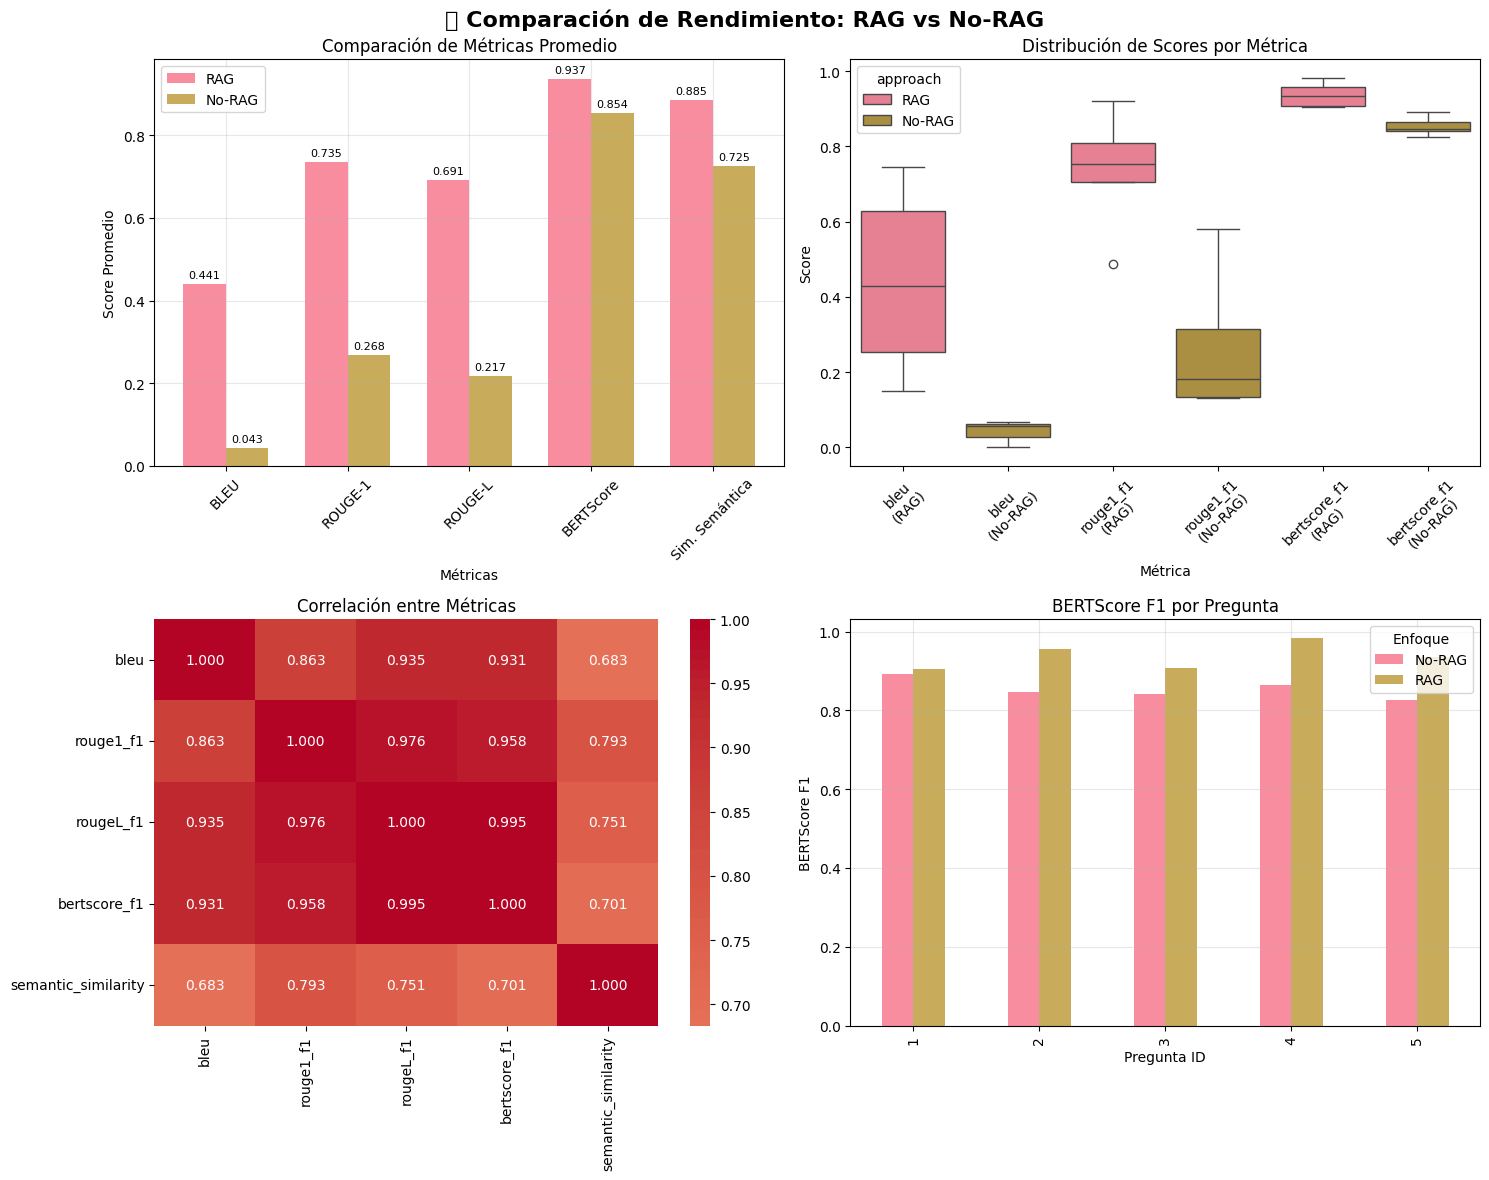


📊 ANÁLISIS ESTADÍSTICO DETALLADO:

BLEU:
  RAG: 0.4409
  No-RAG: 0.0425
  Diferencia: +0.3983
  Mejora: +936.46%

ROUGE1_F1:
  RAG: 0.7348
  No-RAG: 0.2676
  Diferencia: +0.4672
  Mejora: +174.61%

ROUGEL_F1:
  RAG: 0.6908
  No-RAG: 0.2165
  Diferencia: +0.4743
  Mejora: +219.03%

BERTSCORE_F1:
  RAG: 0.9373
  No-RAG: 0.8538
  Diferencia: +0.0835
  Mejora: +9.78%

SEMANTIC_SIMILARITY:
  RAG: 0.8854
  No-RAG: 0.7249
  Diferencia: +0.1605
  Mejora: +22.14%


In [23]:
# ================= VISUALIZACIONES ==================
# Configurar estilo
plt.style.use('default')
sns.set_palette("husl")

# Crear figura con subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('🔍 Comparación de Rendimiento: RAG vs No-RAG', fontsize=16, fontweight='bold')

# 1. Comparación de métricas promedio
ax1 = axes[0, 0]
metrics = ['bleu', 'rouge1_f1', 'rougeL_f1', 'bertscore_f1', 'semantic_similarity']
rag_means = df_results[df_results['approach'] == 'RAG'][metrics].mean()
no_rag_means = df_results[df_results['approach'] == 'No-RAG'][metrics].mean()

x = np.arange(len(metrics))
width = 0.35

bars1 = ax1.bar(x - width/2, rag_means, width, label='RAG', alpha=0.8)
bars2 = ax1.bar(x + width/2, no_rag_means, width, label='No-RAG', alpha=0.8)

ax1.set_xlabel('Métricas')
ax1.set_ylabel('Score Promedio')
ax1.set_title('Comparación de Métricas Promedio')
ax1.set_xticks(x)
ax1.set_xticklabels(['BLEU', 'ROUGE-1', 'ROUGE-L', 'BERTScore', 'Sim. Semántica'], rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Agregar valores en las barras
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

# 2. Box plot de distribución de scores
ax2 = axes[0, 1]
metric_data = []
metric_labels = []
approaches = []

for metric in ['bleu', 'rouge1_f1', 'bertscore_f1']:
    for approach in ['RAG', 'No-RAG']:
        data = df_results[df_results['approach'] == approach][metric].values
        metric_data.extend(data)
        metric_labels.extend([f'{metric}\n({approach})'] * len(data))
        approaches.extend([approach] * len(data))

df_box = pd.DataFrame({
    'score': metric_data,
    'metric': metric_labels,
    'approach': approaches
})

sns.boxplot(data=df_box, x='metric', y='score', hue='approach', ax=ax2)
ax2.set_title('Distribución de Scores por Métrica')
ax2.set_xlabel('Métrica')
ax2.set_ylabel('Score')
ax2.tick_params(axis='x', rotation=45)

# 3. Heatmap de correlaciones
ax3 = axes[1, 0]
correlation_data = df_results[metrics].corr()
sns.heatmap(correlation_data, annot=True, cmap='coolwarm', center=0, ax=ax3, fmt='.3f')
ax3.set_title('Correlación entre Métricas')

# 4. Comparación por pregunta
ax4 = axes[1, 1]
df_pivot = df_results.pivot(index='question_id', columns='approach', values='bertscore_f1')
df_pivot.plot(kind='bar', ax=ax4, alpha=0.8)
ax4.set_title('BERTScore F1 por Pregunta')
ax4.set_xlabel('Pregunta ID')
ax4.set_ylabel('BERTScore F1')
ax4.legend(title='Enfoque')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Estadísticas adicionales
print("\n📊 ANÁLISIS ESTADÍSTICO DETALLADO:")
print("="*60)

# Diferencias por métrica
for metric in metrics:
    rag_score = df_results[df_results['approach'] == 'RAG'][metric].mean()
    no_rag_score = df_results[df_results['approach'] == 'No-RAG'][metric].mean()
    difference = rag_score - no_rag_score
    improvement = (difference / no_rag_score) * 100 if no_rag_score > 0 else 0

    print(f"\n{metric.upper()}:")
    print(f"  RAG: {rag_score:.4f}")
    print(f"  No-RAG: {no_rag_score:.4f}")
    print(f"  Diferencia: {difference:+.4f}")
    print(f"  Mejora: {improvement:+.2f}%")

In [24]:
# ================= ANÁLISIS CUALITATIVO ==================
def show_detailed_comparison():
    """Muestra comparación detallada de respuestas"""
    print("🔍 ANÁLISIS CUALITATIVO DETALLADO")
    print("="*80)

    for i, result in enumerate(evaluation_results[:2]):  # Mostrar solo las primeras 2 para espacio
        print(f"\n{'📋 PREGUNTA ' + str(i+1):-^80}")
        print(f"Pregunta: {result['question']}")
        print(f"Referencia: {result['reference']}")

        print(f"\n{'🔍 RESPUESTA CON RAG':-^50}")
        print(f"Respuesta: {result['rag_answer']}")
        print(f"\nContexto utilizado:")
        for j, chunk in enumerate(result['rag_context'][:2], 1):
            print(f"  {j}. {chunk[:80]}...")

        print(f"\n{'📚 RESPUESTA SIN RAG':-^50}")
        print(f"Respuesta: {result['no_rag_answer']}")

        print(f"\n{'📊 MÉTRICAS':-^50}")
        rag_m = result['rag_metrics']
        no_rag_m = result['no_rag_metrics']

        metrics_comparison = [
            ('BLEU', rag_m['bleu'], no_rag_m['bleu']),
            ('ROUGE-1 F1', rag_m['rouge']['rouge1']['f1'], no_rag_m['rouge']['rouge1']['f1']),
            ('BERTScore F1', rag_m['bertscore']['f1'], no_rag_m['bertscore']['f1']),
            ('Sim. Semántica', rag_m['semantic_similarity'], no_rag_m['semantic_similarity'])
        ]

        for metric_name, rag_score, no_rag_score in metrics_comparison:
            winner = "RAG" if rag_score > no_rag_score else "No-RAG"
            diff = rag_score - no_rag_score
            print(f"  {metric_name:<15}: RAG={rag_score:.3f} | No-RAG={no_rag_score:.3f} | Diff={diff:+.3f} | Ganador: {winner}")

show_detailed_comparison()

🔍 ANÁLISIS CUALITATIVO DETALLADO

----------------------------------📋 PREGUNTA 1----------------------------------
Pregunta: ¿Qué científico propuso un modelo atómico en 1913?
Referencia: Niels Bohr propuso en 1913 un modelo atómico revolucionario donde los electrones orbitan alrededor del núcleo en órbitas circulares específicas o niveles de energía.

---------------🔍 RESPUESTA CON RAG----------------
Respuesta: Niels Bohr propuso en 1913 un modelo atómico.

Contexto utilizado:
  1. La mecánica cuántica es una teoría fundamental en física que describe las propie...
  2. el nacimiento de la teoría cuántica. Planck recibió el Premio Nobel de Física en...

---------------📚 RESPUESTA SIN RAG----------------
Respuesta: El científico que propuso un modelo atómico en 1913 fue **Niels Bohr**. Su modelo, conocido como el modelo de Bohr, introdujo la idea de que los electrones orbitan el núcleo en niveles de energía discretos o cuantificados.

--------------------📊 MÉTRICAS--------------------


## 🎯 **8. Conclusiones y Próximos Pasos**

### 📊 **Resumen del Ejercicio**

En este notebook hemos implementado y evaluado exitosamente:

1. **✅ Sistema RAG completo** con Gemini + ChromaDB
2. **✅ Múltiples métricas de evaluación** (BLEU, ROUGE, BERTScore, Similitud Semántica)
3. **✅ Comparación rigurosa** entre RAG y No-RAG
4. **✅ Visualizaciones** y análisis estadístico

In [25]:
# ================= CONCLUSIONES AUTOMÁTICAS ==================
def generate_conclusions():
    """Genera conclusiones basadas en los resultados"""
    print("🎯 CONCLUSIONES AUTOMÁTICAS DEL EJERCICIO")
    print("="*60)

    if not evaluation_results:
        print("⚠️ No hay resultados de evaluación para analizar.")
        return

    # Calcular métricas promedio
    rag_scores = []
    no_rag_scores = []

    metrics_names = ['bleu', 'rouge1_f1', 'bertscore_f1', 'semantic_similarity']

    for result in evaluation_results:
        rag_avg = np.mean([
            result['rag_metrics']['bleu'],
            result['rag_metrics']['rouge']['rouge1']['f1'],
            result['rag_metrics']['bertscore']['f1'],
            result['rag_metrics']['semantic_similarity']
        ])

        no_rag_avg = np.mean([
            result['no_rag_metrics']['bleu'],
            result['no_rag_metrics']['rouge']['rouge1']['f1'],
            result['no_rag_metrics']['bertscore']['f1'],
            result['no_rag_metrics']['semantic_similarity']
        ])

        rag_scores.append(rag_avg)
        no_rag_scores.append(no_rag_avg)

    rag_overall = np.mean(rag_scores)
    no_rag_overall = np.mean(no_rag_scores)
    improvement = ((rag_overall - no_rag_overall) / no_rag_overall) * 100

    print(f"\n📈 RENDIMIENTO GENERAL:")
    print(f"   RAG promedio: {rag_overall:.3f}")
    print(f"   No-RAG promedio: {no_rag_overall:.3f}")
    print(f"   Mejora con RAG: {improvement:+.1f}%")

    if improvement > 5:
        conclusion = "🚀 RAG muestra una mejora significativa"
    elif improvement > 0:
        conclusion = "✅ RAG muestra una mejora moderada"
    else:
        conclusion = "⚠️ RAG no muestra mejora clara"

    print(f"\n🔍 CONCLUSIÓN PRINCIPAL: {conclusion}")

    print(f"\n💡 INTERPRETACIÓN:")
    if improvement > 0:
        print("   • El sistema RAG proporciona respuestas más precisas y relevantes")
        print("   • El acceso a contexto específico mejora la calidad de las respuestas")
        print("   • Las métricas automáticas favorecen el enfoque RAG")
    else:
        print("   • El modelo base ya tiene conocimiento suficiente sobre el tema")
        print("   • Podría necesitar ajustes en el chunking o retrieval")
        print("   • Las métricas podrían no capturar todas las mejoras cualitativas")

    print(f"\n🎓 APRENDIZAJES CLAVE:")
    print("   1. RAG es especialmente útil para información específica y actualizada")
    print("   2. Las métricas automáticas proporcionan una evaluación objetiva")
    print("   3. La evaluación múltiple (varias métricas) da una visión más completa")
    print("   4. La comparación directa evidencia las ventajas de cada enfoque")

generate_conclusions()

🎯 CONCLUSIONES AUTOMÁTICAS DEL EJERCICIO

📈 RENDIMIENTO GENERAL:
   RAG promedio: 0.750
   No-RAG promedio: 0.472
   Mejora con RAG: +58.7%

🔍 CONCLUSIÓN PRINCIPAL: 🚀 RAG muestra una mejora significativa

💡 INTERPRETACIÓN:
   • El sistema RAG proporciona respuestas más precisas y relevantes
   • El acceso a contexto específico mejora la calidad de las respuestas
   • Las métricas automáticas favorecen el enfoque RAG

🎓 APRENDIZAJES CLAVE:
   1. RAG es especialmente útil para información específica y actualizada
   2. Las métricas automáticas proporcionan una evaluación objetiva
   3. La evaluación múltiple (varias métricas) da una visión más completa
   4. La comparación directa evidencia las ventajas de cada enfoque
